In [1]:
import pandas as pd

# Carga de datos
En primer lugar, cargamos el conjunto de datos como un *dataframe* de pandas.

In [49]:
df = pd.read_csv('../../bonanova3.csv')
df.head()

,start,end,hour_count
0,2023-05-08T00:00:00.000Z,2023-05-08T01:00:00.000Z,80
1,2023-05-08T01:00:00.000Z,2023-05-08T02:00:00.000Z,61
2,2023-05-08T02:00:00.000Z,2023-05-08T03:00:00.000Z,36
3,2023-05-08T03:00:00.000Z,2023-05-08T04:00:00.000Z,51
4,2023-05-08T04:00:00.000Z,2023-05-08T05:00:00.000Z,105


Ahora convertimos el *dataframe* en una serie temporal. Esto se puede hacer en tres pasos:

- convertir el campo *start* a un *datetime*
- establecer la columna de fecha como índice de la serie temporal
- asignar la columna de valores (*day_count*) a una nueva variable, llamada ts.
- ordenar ts (los datos nos vienen en orden temporal invertido)

In [50]:
df['start'] = pd.to_datetime(df['start'])
df.set_index(df['start'], inplace = True)
ts = df['hour_count']
ts = ts.sort_index()

Graficamos la serie de tiempo. 

<Axes: xlabel='start'>

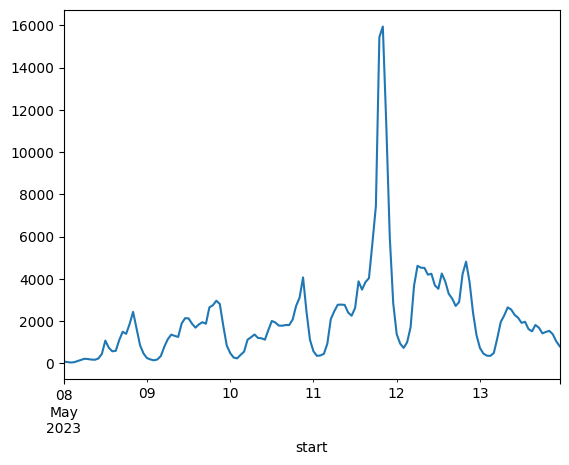

In [51]:
ts.plot()

# Analísis de puntos de ruptura
Mirando el gráfico, decidimos buscar 3 rupturas. Podemos probar con más puntos de rupturas y ver cuánto de estable es el resultado

In [68]:
n_breaks = 2

Preparamos los datos para ser dados como entrada de la biblioteca *ruptures*. Conviertimos la serie temporal en un vector de *numpy*.

In [69]:
import numpy as np
y = np.array(ts.tolist())

Usamos la librería de detección de puntos de ruptura *ruptures*, la cual se puede instalar a través del comando 
`pip install ruptures`.

In [70]:
import ruptures as rpt

*ruptures* ofrece seis modelos diferentes para detectar puntos de ruptura: Dynp, KernelCPD, Pelt, Binseg, BottomUp, Window. Cada modelo debe construirse, entrenarse (a través de la función fit()) y luego usarse para la predicción. La función predict() recibe como entrada el número de puntos de ruptura a identificar. Aquí explotamos el modelo Dynp, que corresponde al de Programación Dinámica.

In [71]:
model = rpt.Dynp(model="l1")
model.fit(y)
breaks = model.predict(n_bkps=n_breaks)

Dado que *ruptures* devuelve el índice en el que ocurre el cambio estructural, recuperamos la fecha de la serie orignal original ts. Recorremos el vector `breaks` hasta el penultimo valor, ya que contiene los limites de las partición generada por los puntos de rupturas, y por lo tanto el último valor siempre es el indice del último punto de datos.

In [72]:
breaks_rpt = []
for i in breaks[:-1]:
    breaks_rpt.append(ts.index[i-1])
breaks_rpt = pd.to_datetime(breaks_rpt)
breaks_rpt

DatetimeIndex(['2023-05-11 07:00:00+00:00', '2023-05-12 23:00:00+00:00'], dtype='datetime64[ns, UTC]', freq=None)

Ahora graficamos los resultados aprovechando la librería *matplotlib*.

In [73]:
breaks_rpt

DatetimeIndex(['2023-05-11 07:00:00+00:00', '2023-05-12 23:00:00+00:00'], dtype='datetime64[ns, UTC]', freq=None)

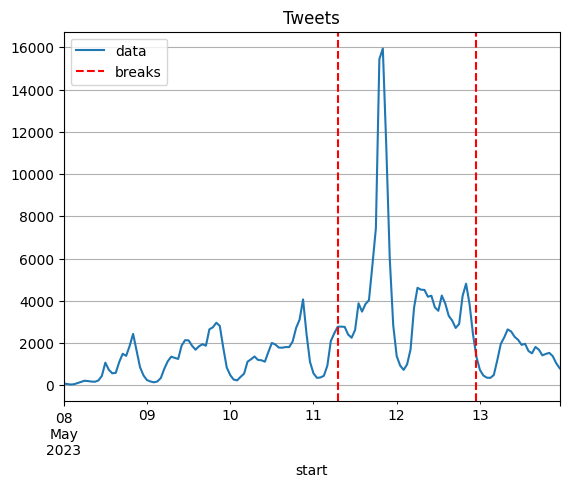

In [74]:
import matplotlib.pyplot as plt
ts.plot(label='data')
plt.title('Tweets')
print_legend = True
for i in breaks_rpt:
    if print_legend:
        plt.axvline(i, color='red',linestyle='dashed', label='breaks')
        print_legend = False
    else:
        plt.axvline(i, color='red',linestyle='dashed')
plt.grid()
plt.legend()
plt.show()

# Análisis de valores atípicos

La detección de valores atípicos es una técnica que permite la identificación de puntos de datos *extraños* en un conjunto de datos. La detección de valores atípicos en un conjunto de datos implica el descubrimiento de elementos con un comportamiento anormal. Para ello usaremos la libreria *pyod*.

In [67]:
from pyod.models.knn import KNN

Preparamos los datos para ser dados como entrada de la librerua *pyod*. Conviertimos la serie temporal en un vector de *numpy* con la forma apropiada.

In [47]:
Y=np.array(ts.tolist()).reshape(-1,1)

Para la detección de valores atípicos usaremos un modelo basado en la proximidad. Estos modelos consideran los valores atípicos como puntos que están aislados del resto de las observaciones. La libreria *pyod* implementa varios algoritmos, en este caso vamos a usar el modelo KNN.

Construimos el modelo KNN con el compando `clf=KNN()` y lo ajustamos a nuestros datos `clf.fit(Y)`. 
Finalmente, predecimos los valores atípicos a través de la función `predict()`.

In [48]:
clf = KNN()
clf.fit(Y)

outliers = clf.predict(Y)


La variable de valores atípicos es una matriz que contiene 1 si el valor correspondiente en Y es un valor atípico, 0 en caso contrario. Por lo tanto, puedo calcular la posición de los valores atípicos a través de la función *numpy* llamada `where()`. 

Graficamos resultados. En primer lugar, calculamos Y_outliers y X_outliers

In [23]:
X=ts.index
Y_outliers = Y[np.where(outliers==1)]
X_outliers = X[np.where(outliers==1)]
Y_inliers = Y[np.where(outliers==0)]
X_inliers = X[np.where(outliers==0)]

Luego, dibujamos un diagrama de dispersión para los valores atípicos por encima del grafico de nuestros datos.

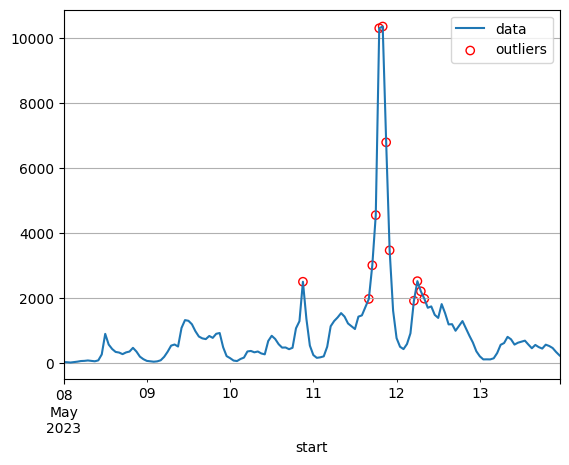

In [24]:
ts.plot(label='data')
plt.scatter(X_outliers, Y_outliers, edgecolor='red',color='none',label='outliers')

plt.legend()
plt.grid()

plt.show()

Cada algoritmo de detección de valores atípicos calcula una puntuación de anomalía para cada punto de datos. Cuanto mayor sea la puntuación de anomalía de un punto de datos, mayor será la probabilidad de que el punto de datos sea un valor atípico. Calculamos la puntuación de anomalía a través de `decision_function()`.

In [25]:
anomaly_score = clf.decision_function(Y) 

Graficamos un histograma que muestra la puntuación de anomalía y una línea vertical que muestra la puntuación de anomalía mínima utilizada por el algoritmo para detectar un valor atípico. 

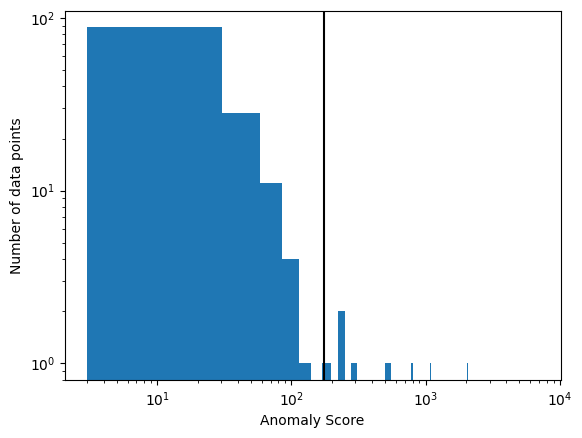

In [26]:
min_outlier_anomaly_score = np.floor(np.min(anomaly_score[np.where(outliers==1)])*10)/10
plt.hist(anomaly_score,bins=250,log=True)
plt.axvline(min_outlier_anomaly_score, c='k')
plt.xlabel('Anomaly Score')
plt.ylabel('Number of data points')
plt.loglog()
plt.show()



Puesto que la distribución de puntuación de anomalía es de cola larga en este caso, hemos graficado el histograma en escala logaritmica.

Ahora, podemos definir manualmente los valores atípicos. Por ejemplo, dada la distribución obtenida, podemos considerar atípicos todos los puntos de datos con una puntuación de anomalía mayor que 10000.

In [27]:
X=ts.index
Y_outliers = Y[np.where(anomaly_score >= 500)]
X_outliers = X[np.where(anomaly_score >= 500)]
Y_inliers = Y[np.where(anomaly_score < 500)]
X_inliers = X[np.where(anomaly_score < 500)]

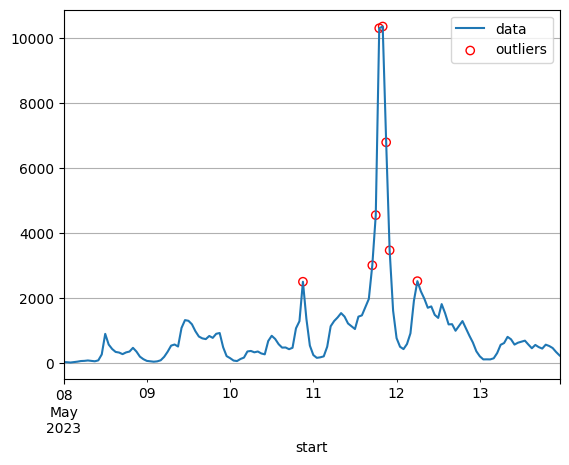

In [28]:
ts.plot(label='data')
plt.scatter(X_outliers, Y_outliers, edgecolor='red',color='none',label='outliers')

plt.legend()
plt.grid()
plt.show()

In [29]:
X[np.where(anomaly_score >= 400)]

DatetimeIndex(['2023-05-10 21:00:00+00:00', '2023-05-11 17:00:00+00:00',
               '2023-05-11 18:00:00+00:00', '2023-05-11 19:00:00+00:00',
               '2023-05-11 20:00:00+00:00', '2023-05-11 21:00:00+00:00',
               '2023-05-11 22:00:00+00:00', '2023-05-12 06:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='start', freq=None)